In [30]:
import pandas as pd 
from datetime import datetime    # To access datetime 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.api import ExponentialSmoothing

%matplotlib inline 

plt.rcParams["figure.figsize"] = (20,10) #Changes the plot size

In [31]:
data = pd.read_csv('2014-2019.csv')
data['Datetime'] = pd.to_datetime(data.Datetime, format='%d-%m-%y %H:%M')
data.set_index('Datetime', inplace = True) #Sets the datetime as the index

In [32]:
for count, value in enumerate(data.values, start=0):  # Checks for outliers in the data
    if value <= 400 or value >= 20000 or pd.isna(data.values[count]): #ps.isna checks if data is na
        data.values[count] = data.values[count - 168*4]  # Takes previous week's value

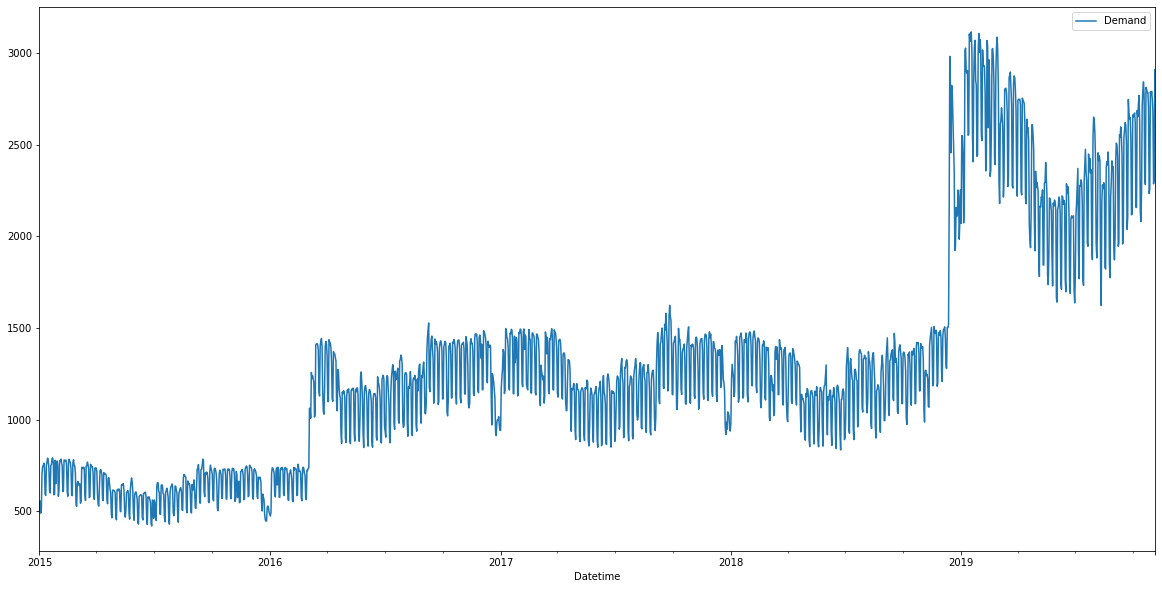

In [33]:
data=data['2015':]
data = data.resample('D').mean() # Takes the daily mean
datacopy = data.copy()
data.plot()

### Accuracy metrics

In [34]:
def accuracy_metrics(actual, forecast):
    MAPE = np.mean(np.abs(forecast - actual)/np.abs(actual)) #Mean Absolute Percent Error
    ME = np.mean(forecast - actual) #Mean Error
    MAE = np.mean(np.abs(forecast - actual)) #Mean Absolute Error
    MPE = np.mean((forecast - actual)/actual) #Mean Percent Error
    RMSE = np.mean((forecast - actual)**2)**.5  # Root Mean Squared Error
    MINS = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    MAXS = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    MinMax = 1 - np.mean(MINS/MAXS)             # Min-Max Error
    
    return 'MAPE:\t\t\t{:.2f}%\nME:\t\t\t{:.2f}Kw\nMAE:\t\t\t{:.2f}Kw\nMPE:\t\t\t{:.2f}%\nRMSE:\t\t\t{:.2f}Kw\nMin-Max Error:\t\t{:.2f}Kw'\
            .format(MAPE*100, ME, MAE, MPE*100, RMSE, MinMax)

## Predicting One Month Ahead

In [35]:
split = int(len(data)-31)
train = data[:split]
test = data[split:]
view = '2019'

### Simple Average Approach

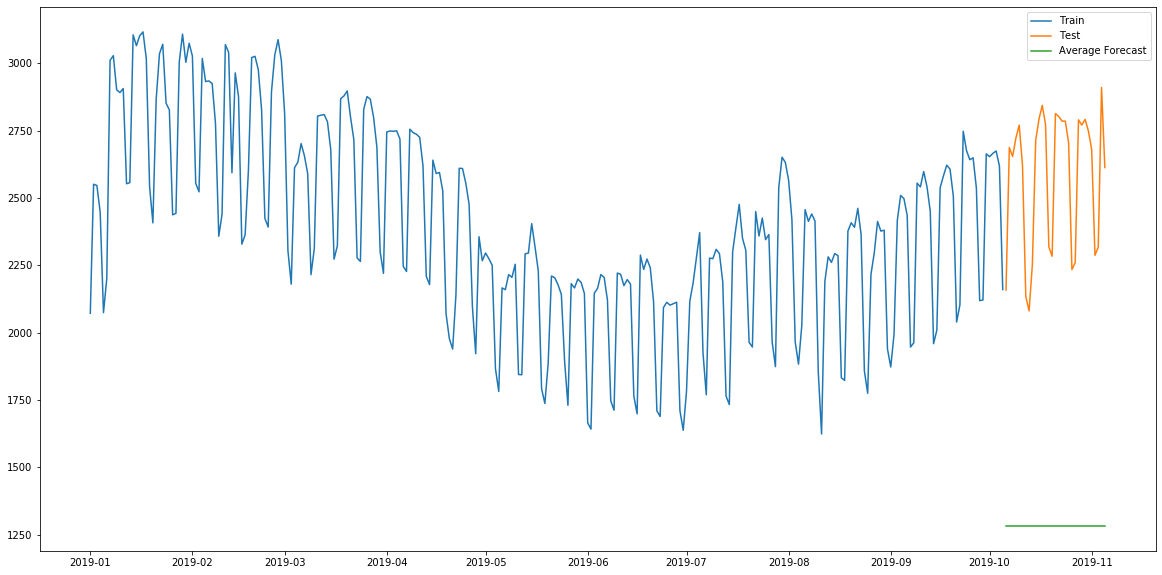

In [36]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Demand'].mean()

plt.plot(train[view:]['Demand'], label='Train')
plt.plot(test['Demand'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

In [37]:
#Checking Accuracy Metrics
actual = test.Demand
forecast =  y_hat_avg.avg_forecast
print(accuracy_metrics(actual, forecast))

MAPE:			49.89%
ME:			-1302.46Kw
MAE:			1302.46Kw
MPE:			-49.89%
RMSE:			1326.85Kw
Min-Max Error:		0.50Kw


### Moving Average Approcach

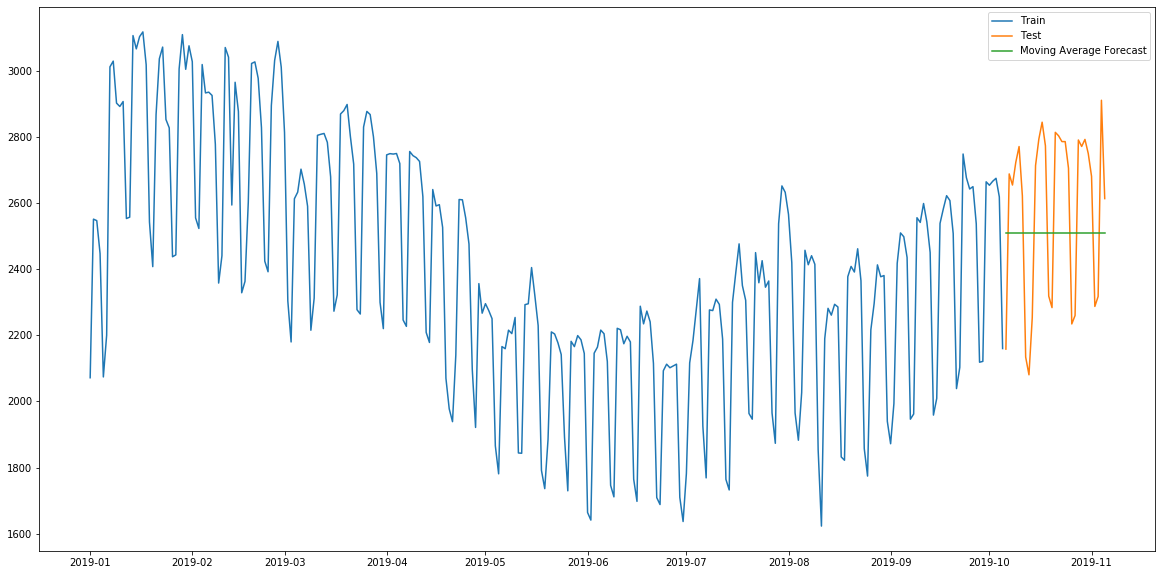

In [38]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['Demand'].rolling(7).mean().iloc[-1]

plt.plot(train[view:]['Demand'], label='Train')
plt.plot(test['Demand'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [39]:
#Checking Accuracy Metrics
actual = test.Demand
forecast = y_hat_avg.moving_avg_forecast
print(accuracy_metrics(actual, forecast))

MAPE:			9.97%
ME:			-75.89Kw
MAE:			253.51Kw
MPE:			-1.92%
RMSE:			264.37Kw
Min-Max Error:		0.09Kw


### The Naive Approach
#### Using the previous week's value

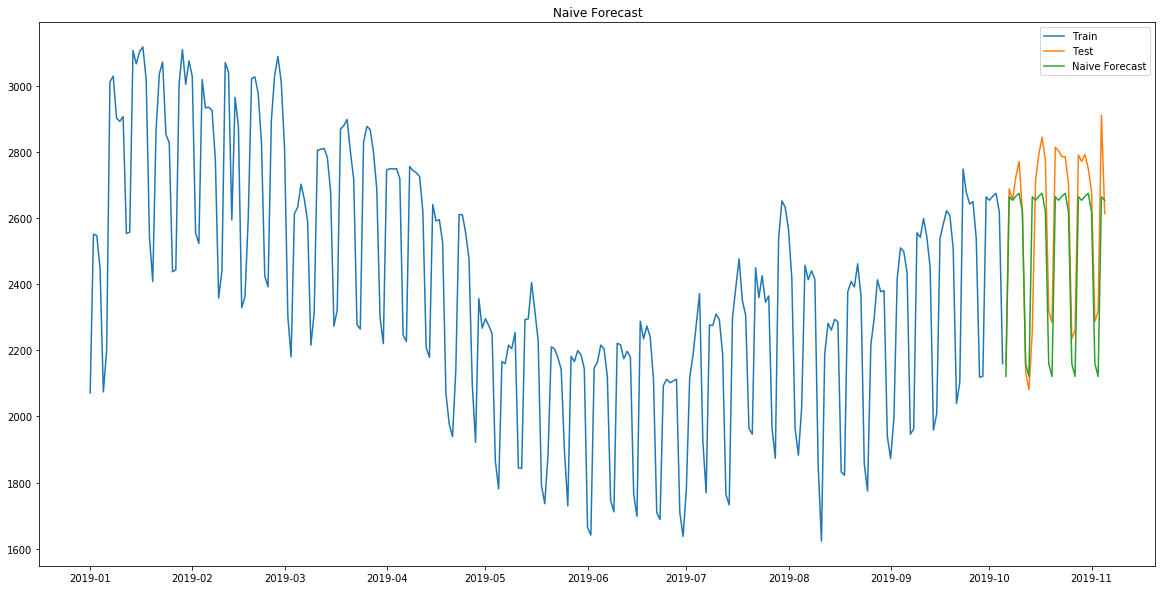

In [40]:
dd= np.asarray(train.Demand)
y_hat = test.copy()

index = -7
for i in range(len(test)):
    y_hat.values[i] = dd[index]
    index +=1
    if index == 0:
        index = -7
y_hat['Naive'] = y_hat['Demand']

plt.plot(train[view:].index, train[view]['Demand'], label='Train')
plt.plot(test.index,test['Demand'], label='Test')
plt.plot(y_hat.index,y_hat['Naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [41]:
#Checking Accuracy Metrics
actual = test.Demand
forecast =  y_hat.Naive
print(accuracy_metrics(actual, forecast))

MAPE:			4.38%
ME:			-78.66Kw
MAE:			112.01Kw
MPE:			-2.90%
RMSE:			137.33Kw
Min-Max Error:		0.04Kw


### Holt-Winter Method

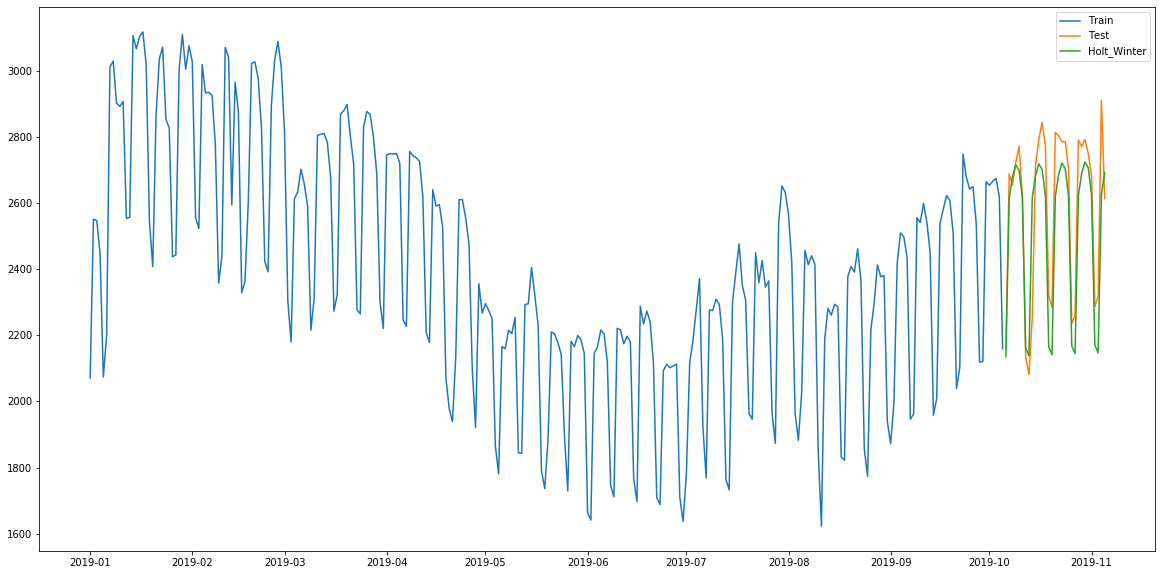

In [42]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Demand']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))

plt.plot( train[view:]['Demand'], label='Train')
plt.plot(test['Demand'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [43]:
#Checking Accuracy Metrics
actual = test.Demand
forecast = y_hat_avg.Holt_Winter
print(accuracy_metrics(actual, forecast))

MAPE:			3.97%
ME:			-65.64Kw
MAE:			101.31Kw
MPE:			-2.41%
RMSE:			127.41Kw
Min-Max Error:		0.04Kw


### Auto Regressive Model (AR)

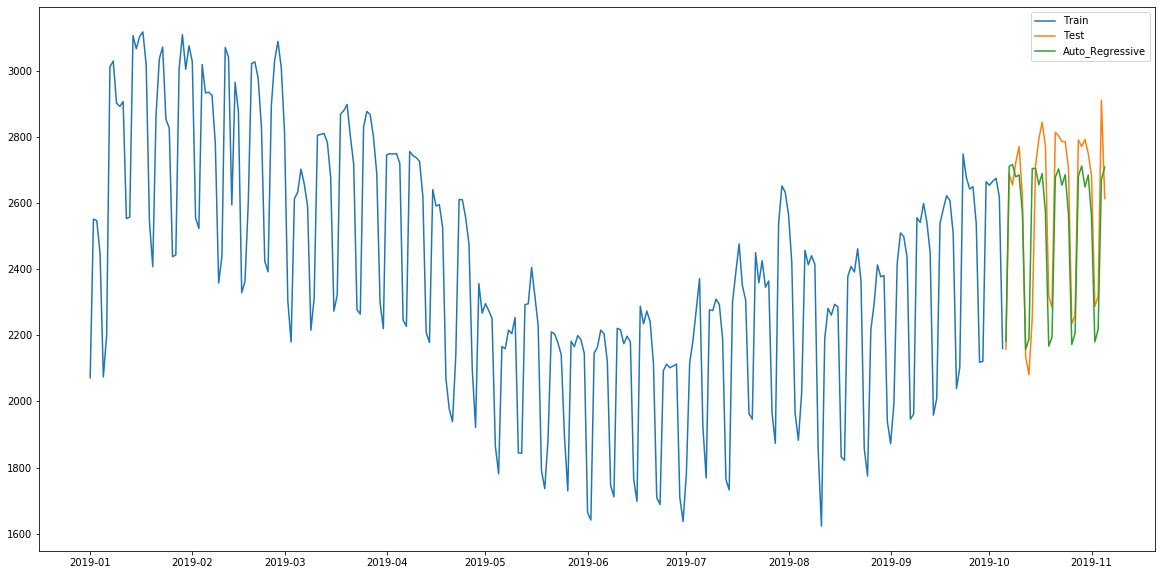

In [44]:
from statsmodels.tsa.ar_model import AR

model_ar = AR(train)
model_ar_fit = model_ar.fit()
y_hat_ar = test.copy()
y_hat_ar['AR'] = model_ar_fit.predict(start=split, end=len(data)) #Was longer by one prediction

plt.plot( train[view:]['Demand'], label='Train')
plt.plot(test['Demand'], label='Test')
plt.plot(y_hat_ar['AR'], label='Auto_Regressive')
plt.legend(loc='best')
plt.show()

In [45]:
#Checking Accuracy Metrics
actual = test.Demand
forecast = y_hat_ar.AR
print(accuracy_metrics(actual, forecast))

MAPE:			4.24%
ME:			-58.14Kw
MAE:			108.85Kw
MPE:			-2.03%
RMSE:			135.66Kw
Min-Max Error:		0.04Kw


### Auto Regressive Integrated Moving Average (ARIMA)

In [46]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [47]:
# import pmdarima as pm
# import warnings
# warnings.filterwarnings('ignore')

# model =pm.auto_arima(train.Demand,m=7,seasonal=True)
# y_hat_avg['ARIMA'] = model.predict(n_periods=len(test))
# model.summary()

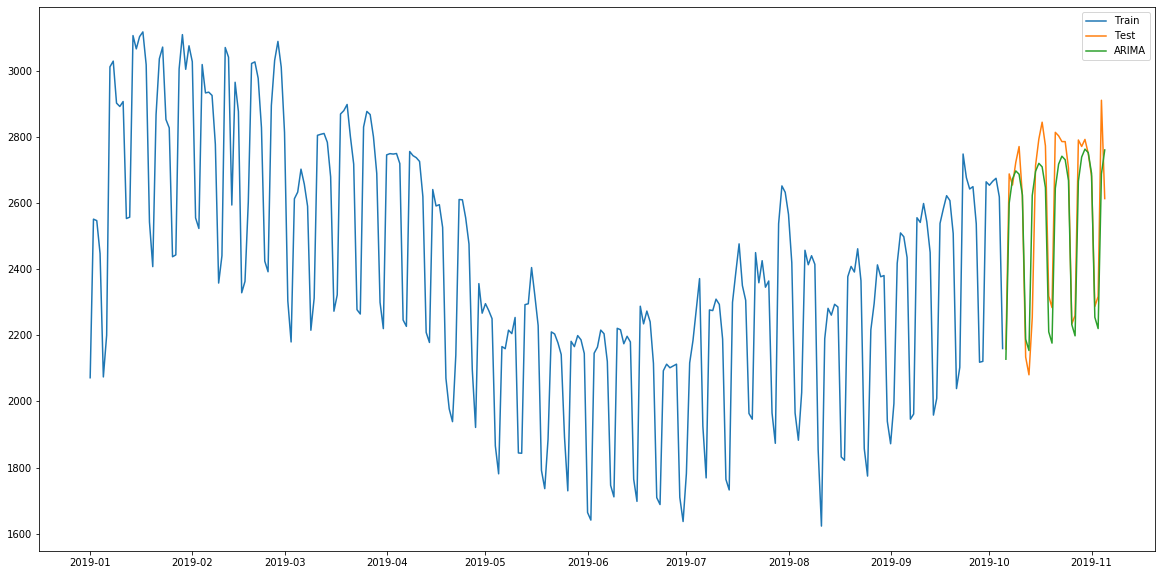

In [48]:
y_hat_avg = test.copy()
model =  SARIMAX(train.Demand, order=(1,1,2),seasonal_order=(1,0,2,7))
model_fit = model.fit()
y_hat_avg['ARIMA'] = model_fit.predict(start="2019-10-06", end="2019-11-05", dynamic=True)

# model_arima = ARIMA(train,order=(6,1,7))
# model_arima_fit = model_arima.fit(disp = -1)
# y_hat_avg['ARIMA'] = model_arima_fit.forecast(steps=len(test))[0]

plt.plot( train[view:]['Demand'], label='Train')
plt.plot(test['Demand'], label='Test')
plt.plot(y_hat_avg['ARIMA'], label='ARIMA')
plt.legend(loc='best')
plt.show()

In [49]:
#Checking Accuracy Metrics
actual = test.Demand
forecast = y_hat_avg.ARIMA
print(accuracy_metrics(actual, forecast))

MAPE:			3.12%
ME:			-35.87Kw
MAE:			79.48Kw
MPE:			-1.23%
RMSE:			109.16Kw
Min-Max Error:		0.03Kw
